In [288]:
import numpy as np
import random
import nibabel as nib
import matplotlib.pyplot as plt
import math
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [266]:
def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / (np.max(img)-np.min(img))
    

In [267]:
image = nib.load('/home/tony/Documents/IBSR_preprocessed/IBSR_02/image.nii.gz').get_data().astype(np.float32)
img = image[:, :, 50, 0]
img = max_min_normalize(img)
img = np.expand_dims(img, axis=2)
img = np.concatenate((img, img, img), 2)
segments = slic(img.astype('double'), n_segments=300, compactness=30)

In [238]:
segments.max()

287

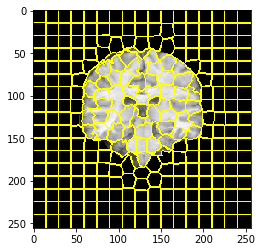

In [239]:
plt.imshow(mark_boundaries(img,segments))

In [246]:
def feature_extract(img, segments, f_range=5, n_vertex=256, tao=0.1):
    step = math.floor(f_range/2)
    n_segments = np.max(segments) + 1
    centroid_list = []
    for i in range(n_vertex):
        if i < n_segments:
            h_mean = int(np.where(segments==i)[0].mean())
            w_mean = int(np.where(segments==i)[1].mean())
            centroid_list.append((h_mean, w_mean))
        else:
            h_mean = int(np.where(segments==0)[0].mean())
            w_mean = int(np.where(segments==0)[1].mean())
            centroid_list.append((h_mean, w_mean))
    
    features = np.zeros((n_vertex, f_range*f_range))
    for i in range(n_vertex):
        h, w = centroid_list[i]
        features[i] = img[h-step:h+step+1, w-step:w+step+1, 0].flatten() 
        
    aj_arr = np.zeros((n_vertex, n_vertex))
    for i in range(n_vertex):
        for j in range(n_vertex):
            diff = features[i] - features[j]
            diff = np.power(diff, 2)
#             for k in range(diff.shape[0]):
#                 diff[k] = math.pow(diff[k], 2)
            l2_norm_square = diff.sum()   
            aj_arr[i, j] = math.exp(-l2_norm_square / (2*tao*tao))
    
    return features, aj_arr

In [247]:
def back_to_label(segments, class_output):
    output = np.zeros((segments.shape[0], segments.shape[1]))
    for i in range(class_output.shape[0]):
        output[np.where(segments==i)] = class_output[i]
    return output

In [260]:
f, a = feature_extract(img, segments, 7, 300, 7)

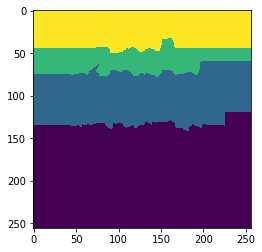

In [259]:
class_output = np.asarray([3]*50 + [2]*30 + [1]*70)
output = back_to_label(segments, class_output)
plt.imshow(output)

In [203]:
def vertex_set(img, segments, filter_size, num):
    step = math.floor(filter_size/2)
    num_of_segments = np.max(segments) + 1
    centroid_list = []
    for i in range(num_of_segments):
        h_mean = int(np.where(segments==i)[0].mean())
        w_mean = int(np.where(segments==i)[1].mean())
        val_mean = img[h_mean-step:h_mean+step+1, w_mean-step:w_mean+step+1].mean()
        centroid_list.append((h_mean, w_mean, val_mean))
        centroid_list.sort(key = itemgetter(2), reverse=True)
    
    features = np.zeros((num, filter_size*filter_size))
    for i in range(num):
        h, w, v = centroid_list[i]
        features[i] = img[h-step:h+step+1, w-step:w+step+1, 0].flatten() 
    
    return features, centroid_list

In [204]:
def adjacency_array(features, tao):
    n = features.shape[0]
    aj_arr = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            diff = features[i] - features[j]
            for k in range(diff.shape[0]):
                diff[k] = math.pow(diff[k], 2)
            l2_norm_square = diff.sum()   
            aj_arr[i, j] = math.exp(-l2_norm_square / (2*tao*tao))
    return aj_arr

In [205]:
features, centroid_list = vertex_set(img, segments, 7, 150)

In [206]:
aj_arr = adjacency_array(features, 0.5)

In [207]:
def back_to_label(segments, class_output, centroid_list):
    output = np.zeros((segments.shape[0], segments.shape[1]))
    for i in range(class_output.shape[0]):
        h = centroid_list[i][0]
        w = centroid_list[i][1]
        lab_num = segments[h, w]
        output[np.where(segments==lab_num)] = class_output[i]
    return output

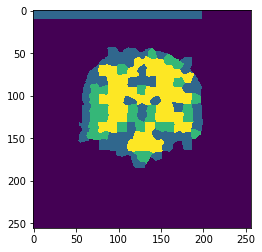

In [208]:
class_output = np.asarray([3]*50 + [2]*30 + [1]*70)
output = back_to_label(segments, class_output, centroid_list)
plt.imshow(output)

In [109]:
info = np.zeros((img.shape[0], img.shape[1], 3))
n = 7
step = math.floor(n/2)
# for c in centroid_list:
#     for i in range(c[0]-3, c[0]+3+1):
#         for j in range(c[1]-3, c[1]+3+1):
#             info[i, j, 0] = img[i, j, 0] 
#             info[i, j, 1] = img[i, j, 1] 
#             info[i, j, 2] = img[i, j, 2] 

for c in centroid_list:
    info[c[0]-step:c[0]+step+1, c[1]-step:c[1]+step+1] = img[c[0]-step:c[0]+step+1, c[1]-step:c[1]+step+1]

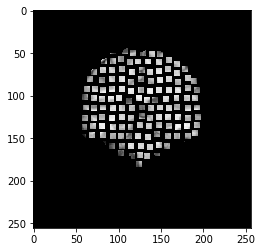

In [134]:
plt.imshow(info)

In [47]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange


class Cluster(object):
    # global cluster num
    cluster_index = 0

    def __init__(self, h, w, l=0, a=0, b=0):
        """
        Args:
            h: row position
            w: column position
            l: lab l value
            a: lab a value
            b: lab b value
        """
        self.update(h, w, l, a, b)
        self.pixels = []
        self.no = self.cluster_index
        Cluster.cluster_index += 1

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

    def __str__(self):
        return "{},{}:{} {} {} ".format(self.h, self.w, self.l, self.a, self.b)

    def __repr__(self):
        return self.__str__()


class SLICProcessor2D(object):
    def __init__(self, img, K, M):
        """
        Args:
            img: 2D numpy array
            K: num of seeds
            M: parameter for Dc
        """
        self.K = K
        self.M = M

        self.data = self.input_rgb2lab(img)
        self.image_height = self.data.shape[0]
        self.image_width = self.data.shape[1]
        self.N = self.image_height * self.image_width
        self.S = int(math.sqrt(self.N / self.K))

        self.clusters = []
        self.label = {}
        self.dis = np.full((self.image_height, self.image_width), np.inf)
        
        self.output_image = self.data.copy()
        
    def input_rgb2lab(self, img):
        lab_arr = color.rgb2lab(img)
        return lab_arr
        
    def make_cluster(self, h, w):
        return Cluster(h, w, self.data[h][w][0],
                                    self.data[h][w][1],
                                    self.data[h][w][2])

    def init_clusters(self):
        # beginning of h and w
        h = self.S / 2
        w = self.S / 2
        while h < self.image_height: # from top to down
            while w < self.image_width: # from left to right
                self.clusters.append(self.make_cluster(int(h), int(w)))
                w += self.S
            w = self.S / 2
            h += self.S

    def get_gradient(self, h, w):
        # if a 3x3 mask will exceed the image
        if w + 1 >= self.image_width:
            w = self.image_width - 2
        if h + 1 >= self.image_height:
            h = self.image_height - 2

        gradient = self.data[w + 1][h + 1][0] - self.data[w][h][0] + \
                   self.data[w + 1][h + 1][1] - self.data[w][h][1] + \
                   self.data[w + 1][h + 1][2] - self.data[w][h][2]
        return gradient

    def relocate_clusters_by_gradient(self):
        for cluster in self.clusters:
            # the gradient of current location
            cluster_gradient = self.get_gradient(cluster.h, cluster.w)
            # gradients within a 3x3 mask
            for dh in range(-1, 2):
                for dw in range(-1, 2):
                    _h = cluster.h + dh
                    _w = cluster.w + dw
                    new_gradient = self.get_gradient(_h, _w)
                    if new_gradient < cluster_gradient:
                        cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])
                        cluster_gradient = new_gradient

    def assign(self):
        """
        assign pixels to clusters
        """
        for cluster in self.clusters:
            # pixels in the range of a cluster
            for h in range(cluster.h - 2 * self.S, cluster.h + 2 * self.S):
                if h < 0 or h >= self.image_height: continue
                for w in range(cluster.w - 2 * self.S, cluster.w + 2 * self.S):
                    if w < 0 or w >= self.image_width: continue
                        
                    L, A, B = self.data[h][w]
                    Dc = math.sqrt(
                        math.pow(L - cluster.l, 2) +
                        math.pow(A - cluster.a, 2) +
                        math.pow(B - cluster.b, 2))
                    Ds = math.sqrt(
                        math.pow(h - cluster.h, 2) +
                        math.pow(w - cluster.w, 2))
                    D = math.sqrt(math.pow(Dc / self.M, 2) + math.pow(Ds / self.S, 2))
                    
                    # if D is smaller than the older one, reassign the pixel
                    if D < self.dis[h][w]:
                        if (h, w) not in self.label:
                            self.label[(h, w)] = cluster
                            cluster.pixels.append((h, w))
                        else:
                            self.label[(h, w)].pixels.remove((h, w))
                            self.label[(h, w)] = cluster
                            cluster.pixels.append((h, w))
                        self.dis[h][w] = D

    def relocate_clusters(self):
        for cluster in self.clusters:
            sum_h = sum_w = n = 0
            for p in cluster.pixels:
                sum_h += p[0]
                sum_w += p[1]
                n += 1
                _h = int(sum_h / n)
                _w = int(sum_w / n)
                cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])

    def return_output_image(self):
        img = np.copy(self.output_image)
        for cluster in self.clusters:
            for p in cluster.pixels:
                img[p[0]][p[1]][0] = cluster.l
                img[p[0]][p[1]][1] = cluster.a
                img[p[0]][p[1]][2] = cluster.b
            img[cluster.h][cluster.w][0] = 0
            img[cluster.h][cluster.w][1] = 0
            img[cluster.h][cluster.w][2] = 0
        img = color.lab2rgb(img)
        return img

    def iterate(self, iter_times):
        self.init_clusters()
        self.relocate_clusters_by_gradient()
        for i in trange(iter_times):
            self.assign()
            self.relocate_clusters()
        self.output_image =  self.return_output_image()


100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


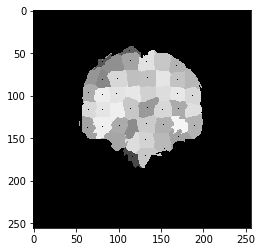

In [49]:
p = SLICProcessor2D(img, 200, 50)
p.iterate(5)
output = p.output_image
plt.imshow(output)

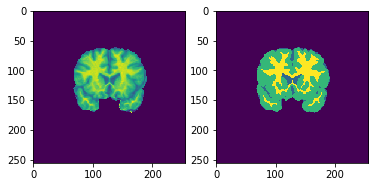

In [379]:
image = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/image_80.nii.gz').get_data().astype(np.float32)
label = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/label_80.nii.gz').get_data().astype(np.int64)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(label)
image = max_min_normalize(image)
image = np.expand_dims(image, axis=2)
image = np.concatenate((image, image, image), 2)
segments = slic(image.astype('double'), n_segments=2000, compactness=20)

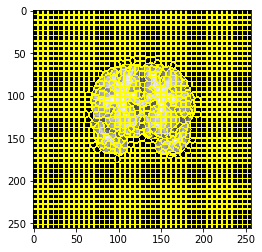

In [380]:
plt.imshow(mark_boundaries(image, segments))

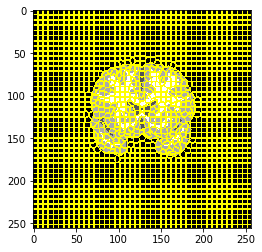

In [385]:
# transform label to feature
n_vertex = 2048
n_class = 4
f_label = np.zeros(n_vertex)

for i in range(segments.max()+1):
    h = int(np.where(segments==i)[0].mean())
    w = int(np.where(segments==i)[1].mean())
    f_label[i] = label[h, w]
    
# for i in range(segments.max()+1):
#     f_label[i] = round(label[np.where(segments==i)].mean())
    
plt.imshow(mark_boundaries(max_min_normalize(label), segments))

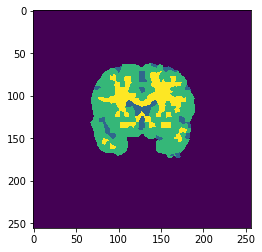

In [386]:
# turn back feature to label
label_new = np.zeros((label.shape[0], label.shape[1]))
for i in range(segments.max()+1):
    label_new[np.where(segments==i)] = f_label[i]
plt.imshow(label_new)

In [395]:
def label_transform(label, segments, n_vertex):
    f_label = np.zeros(n_vertex)
    label_new = np.zeros((label.shape[0], label.shape[1]))
    for i in range(segments.max() + 1):
        where = np.where(segments==i)
        h = int(where[0].mean())
        w = int(where[1].mean())
        label_new[np.where(segments==i)]  = label[h, w] 
    return label_new

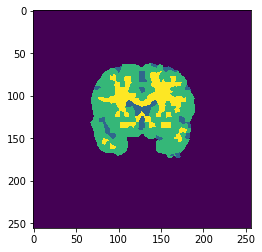

In [396]:
label_new = label_transform(label, segments, n_vertex)
plt.imshow(label_new)

In [405]:
import torch
a = torch.zeros(2, 2).long()
a

tensor([[0, 0],
        [0, 0]])

In [451]:
output = torch.LongTensor(f_label).cuda()
target= torch.LongTensor(label).cuda()
seg = torch.LongTensor(segments).cuda()

img = torch.zeros_like(target).long()

mask0 = torch.zeros_like(target)
mask1 = torch.ones_like(target)

# for i in range(seg_tensor.max() + 1):
#     seg_tensor = np.asarray(seg_tensor.cpu())
#     where = np.where(seg_tensor==i)
#     h = int(where[0].mean())
#     w = int(where[1].mean())
#     seg_tensor = torch.LongTensor(seg_tensor).cuda()
#     img += torch.where(seg_tensor==i, label_tensor[h, w]*mask1, mask0)

for i in range(seg_tensor.max() + 1):
    img += torch.where(seg_tensor==i, output[i]*mask1, mask0)

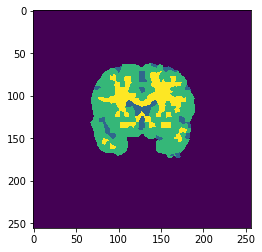

In [433]:
img = np.asarray(img.cpu())
plt.imshow(img)

In [446]:
a = torch.zeros(256, 256, 4)
a.shape

torch.Size([256, 256, 4])

In [452]:
img = torch.unsqueeze(img, 0)
img.shape

torch.Size([1, 256, 256])

In [450]:
a = torch.zeros(256, 256, 4).cuda().scatter_(2, img, 1)
a.shape

torch.Size([256, 256, 4])

In [419]:
f_label_tensor.cpu()

tensor([0, 0, 0,  ..., 0, 0, 0])